In [ ]:
# Run this line in Colab to install the package if it is
# not already installed.
!pip install git+https://github.com/openai/glide-text2im

In [1]:
#Assuming data is already downloaded in Repaint-main

In [1]:
from typing import Tuple

from IPython.display import display
from PIL import Image
import numpy as np
import torch as th
import torch.nn.functional as F

from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)

/home/infres/kbrowder-24/jp/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# This notebook supports both CPU and GPU.
# On CPU, generating one sample may take on the order of 20 minutes.
# On a GPU, it should be under a minute.

has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')

In [18]:
# Create base model.
options = model_and_diffusion_defaults()
options['inpaint'] = False
options['use_fp16'] = has_cuda
options['timestep_respacing'] = '250' # use 100 diffusion steps for fast sampling
model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base', device))
print('total base parameters', sum(x.numel() for x in model.parameters()))

total base parameters 385030726


In [4]:
def get_schedule_jump(t_T, n_sample, jump_length, jump_n_sample,
                      jump2_length=1, jump2_n_sample=1,
                      jump3_length=1, jump3_n_sample=1,
                      start_resampling=100000000):

    jumps = {}
    for j in range(0, t_T - jump_length, jump_length):
        jumps[j] = jump_n_sample - 1

    jumps2 = {}
    for j in range(0, t_T - jump2_length, jump2_length):
        jumps2[j] = jump2_n_sample - 1

    jumps3 = {}
    for j in range(0, t_T - jump3_length, jump3_length):
        jumps3[j] = jump3_n_sample - 1

    t = t_T
    ts = []

    while t >= 1:
        t = t-1
        ts.append(t)

        if (
            t + 1 < t_T - 1 and
            t <= start_resampling
        ):
            for _ in range(n_sample - 1):
                t = t + 1
                ts.append(t)

                if t >= 0:
                    t = t - 1
                    ts.append(t)

        if (
            jumps3.get(t, 0) > 0 and
            t <= start_resampling - jump3_length
        ):
            jumps3[t] = jumps3[t] - 1
            for _ in range(jump3_length):
                t = t + 1
                ts.append(t)

        if (
            jumps2.get(t, 0) > 0 and
            t <= start_resampling - jump2_length
        ):
            jumps2[t] = jumps2[t] - 1
            for _ in range(jump2_length):
                t = t + 1
                ts.append(t)
            jumps3 = {}
            for j in range(0, t_T - jump3_length, jump3_length):
                jumps3[j] = jump3_n_sample - 1

        if (
            jumps.get(t, 0) > 0 and
            t <= start_resampling - jump_length
        ):
            jumps[t] = jumps[t] - 1
            for _ in range(jump_length):
                t = t + 1
                ts.append(t)
            jumps2 = {}
            for j in range(0, t_T - jump2_length, jump2_length):
                jumps2[j] = jump2_n_sample - 1

            jumps3 = {}
            for j in range(0, t_T - jump3_length, jump3_length):
                jumps3[j] = jump3_n_sample - 1

    ts.append(-1)

    # _check_times(ts, -1, t_T)

    return ts

In [5]:
jump_params = {
    "t_T": 250,
    "n_sample": 1,
    "jump_length": 10,
    "jump_n_sample": 10
}

In [6]:
from collections import defaultdict
from tqdm.auto import tqdm

def repaint_p_sample_loop_progressive(
        self,
        model,
        shape,
        noise=None,
        clip_denoised=True,
        denoised_fn=None,
        cond_fn=None,
        model_kwargs=None,
        device=None,
        progress=False,
        conf=None
    ):
        """
        Generate samples from the model and yield intermediate samples from
        each timestep of diffusion.

        Arguments are the same as p_sample_loop().
        Returns a generator over dicts, where each dict is the return value of
        p_sample().
        """
        if device is None:
            device = next(model.parameters()).device
        assert isinstance(shape, (tuple, list))
        if noise is not None:
            image_after_step = noise
        else:
            image_after_step = th.randn(*shape, device=device)

        # debug_steps = conf.pget('debug.num_timesteps')

        self.gt_noises = None  # reset for next image


        pred_xstart = None

        idx_wall = -1
        sample_idxs = defaultdict(lambda: 0)

        if True:
            times = get_schedule_jump(**jump_params)

            time_pairs = list(zip(times[:-1], times[1:]))
            if progress:
                time_pairs = tqdm(time_pairs)

            for t_last, t_cur in time_pairs:
                idx_wall += 1
                t_last_t = th.tensor([t_last] * shape[0],  # pylint: disable=not-callable
                                     device=device)

                if t_cur < t_last:  # reverse
                    with th.no_grad():
                        image_before_step = image_after_step.clone()
                        out = self.p_sample(
                            model,
                            image_after_step,
                            t_last_t,
                            clip_denoised=clip_denoised,
                            denoised_fn=denoised_fn,
                            cond_fn=cond_fn,
                            model_kwargs=model_kwargs,
                            # conf=conf,
                            pred_xstart=pred_xstart
                        )
                        image_after_step = out["sample"]
                        pred_xstart = out["pred_xstart"]

                        sample_idxs[t_cur] += 1

                        yield out

                else:
                    t_shift = 1

                    image_before_step = image_after_step.clone()
                    image_after_step = self.undo(
                        image_before_step, image_after_step,
                        est_x_0=out['pred_xstart'], t=t_last_t+t_shift, debug=False)
                    pred_xstart = out["pred_xstart"]

In [7]:
def _extract_into_tensor(arr, timesteps, broadcast_shape):
    """
    Extract values from a 1-D numpy array for a batch of indices.

    :param arr: the 1-D numpy array.
    :param timesteps: a tensor of indices into the array to extract.
    :param broadcast_shape: a larger shape of K dimensions with the batch
                            dimension equal to the length of timesteps.
    :return: a tensor of shape [batch_size, 1, ...] where the shape has K dims.
    """
    res = th.from_numpy(arr).to(device=timesteps.device)[timesteps].float()
    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]
    return res + th.zeros(broadcast_shape, device=timesteps.device)

def repaint_p_sample(
        self,
        model,
        x,
        t,
        clip_denoised=True,
        denoised_fn=None,
        cond_fn=None,
        model_kwargs=None,
        conf=None,
        meas_fn=None,
        pred_xstart=None,
        idx_wall=-1
    ):
        """
        Sample x_{t-1} from the model at the given timestep.

        :param model: the model to sample from.
        :param x: the current tensor at x_{t-1}.
        :param t: the value of t, starting at 0 for the first diffusion step.
        :param clip_denoised: if True, clip the x_start prediction to [-1, 1].
        :param denoised_fn: if not None, a function which applies to the
            x_start prediction before it is used to sample.
        :param cond_fn: if not None, this is a gradient function that acts
                        similarly to the model.
        :param model_kwargs: if not None, a dict of extra keyword arguments to
            pass to the model. This can be used for conditioning.
        :return: a dict containing the following keys:
                 - 'sample': a random sample from the model.
                 - 'pred_xstart': a prediction of x_0.
        """
        noise = th.randn_like(x)

        if pred_xstart is not None:
            gt_keep_mask = model_kwargs.get('gt_keep_mask')

            gt = model_kwargs['gt']

            alpha_cumprod = _extract_into_tensor(
                self.alphas_cumprod, t, x.shape)


            gt_weight = th.sqrt(alpha_cumprod)
            gt_part = gt_weight * gt

            noise_weight = th.sqrt((1 - alpha_cumprod))
            noise_part = noise_weight * th.randn_like(x)

            weighed_gt = gt_part + noise_part

            x = (
                gt_keep_mask * (
                    weighed_gt
                )
                +
                (1 - gt_keep_mask) * (
                    x
                )
            )

        model_kwargs = {k:model_kwargs[k] for k in model_kwargs if k != 'gt' and k != 'gt_keep_mask'}

        out = self.p_mean_variance(
            model,
            x,
            t,
            clip_denoised=clip_denoised,
            denoised_fn=denoised_fn,
            model_kwargs=model_kwargs,
        )

        nonzero_mask = (
            (t != 0).float().view(-1, *([1] * (len(x.shape) - 1)))
        ) 

        if cond_fn is not None:
            out["mean"] = self.condition_mean(
                cond_fn, out, x, t, model_kwargs=model_kwargs
            )

        sample = out["mean"] + nonzero_mask * \
            th.exp(0.5 * out["log_variance"]) * noise

        result = {"sample": sample,
                  "pred_xstart": out["pred_xstart"], 'gt': model_kwargs.get('gt')}

        return result

In [8]:
def rp_undo(self, image_before_step, img_after_model, est_x_0, t, debug=False):
    return self._undo(img_after_model, t)

def _rp_undo(self, img_out, t):
    beta = _extract_into_tensor(self.betas, t, img_out.shape)

    img_in_est = th.sqrt(1 - beta) * img_out + \
        th.sqrt(beta) * th.randn_like(img_out)

    return img_in_est

In [19]:
from functools import partial
diffusion.p_sample_loop_progressive = partial(repaint_p_sample_loop_progressive, diffusion)
diffusion.p_sample = partial(repaint_p_sample, diffusion)
diffusion.undo = partial(rp_undo, diffusion)
diffusion._undo = partial(_rp_undo, diffusion)

In [10]:
# Create upsampler model.
options_up = model_and_diffusion_defaults_upsampler()
options_up['inpaint'] = True
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = '50' # use 27 diffusion steps for very fast sampling
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample-inpaint', device))
print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))

total upsampler parameters 398368198


In [11]:
def show_images(batch: th.Tensor):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(Image.fromarray(reshaped.numpy()))

def read_image(path: str, size: int = 256) -> Tuple[th.Tensor, th.Tensor]:
    pil_img = Image.open(path).convert('RGB')
    pil_img = pil_img.resize((size, size), resample=Image.BICUBIC)
    img = np.array(pil_img)
    return th.from_numpy(img)[None].permute(0, 3, 1, 2).float() / 127.5 - 1

def read_mask(path: str, size: int = 256) -> Tuple[th.Tensor, th.Tensor]:
    pil_img = Image.open(path).convert('RGB')
    pil_img = pil_img.resize((size, size), resample=Image.BICUBIC)
    img = np.array(pil_img)
    return (th.from_numpy(img)[None].permute(0, 3, 1, 2).float() / 255).int()[:,:1,:,:]

torch.Size([1, 1, 256, 256])


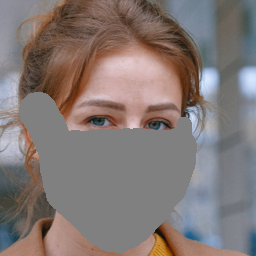

In [12]:
# Sampling parameters
prompt = ""
batch_size = 1
guidance_scale = 1.0

# Tune this parameter to control the sharpness of 256x256 images.
# A value of 1.0 is sharper, but sometimes results in grainy artifacts.
upsample_temp = 0.997

src_img_path = 'RePaint-main/data/datasets/gts/face/000000.png'
# src_img_path = 'glide-text2im-main/notebooks/grass.png'

# Source image we are inpainting
source_image_256 = read_image(src_img_path, size=256)
source_image_64 = read_image(src_img_path, size=64)

src_mask_path = 'RePaint-main/data/datasets/gt_keep_masks/face/000000.png'

# The mask should always be a boolean 64x64 mask, and then we
# can upsample it for the second stage.
source_mask_64 = read_mask(src_mask_path, size=64)
source_mask_256 = read_mask(src_mask_path, size=256)
# source_mask_64 = th.ones_like(source_image_64)[:, :1]
# source_mask_64[:, :, 20:] = 0
# source_mask_256 = F.interpolate(source_mask_64, (256, 256), mode='nearest')
#show mask
# show_images(source_mask_256)
print(source_mask_256.shape)
# Visualize the image we are inpainting
show_images(source_image_256 * source_mask_256)

100%|██████████| 4570/4570 [01:47<00:00, 42.42it/s]


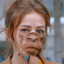

In [20]:
##############################
# Sample from the base model #
##############################

# Create the text tokens to feed to the model.
tokens = model.tokenizer.encode(prompt)
tokens, mask = model.tokenizer.padded_tokens_and_mask(
    tokens, options['text_ctx']
)

# Create the classifier-free guidance tokens (empty)
full_batch_size = batch_size * 2
uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
    [], options['text_ctx']
)

# Pack the tokens together into model kwargs.
model_kwargs = dict(
    tokens=th.tensor(
        [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size + [uncond_mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),

    gt=(source_image_64 * source_mask_64).repeat(full_batch_size, 1, 1, 1).to(device),
    gt_keep_mask=source_mask_64.repeat(full_batch_size, 1, 1, 1).to(device),

    # Masked inpainting image
    # inpaint_image=(source_image_64 * source_mask_64).repeat(full_batch_size, 1, 1, 1).to(device),
    # inpaint_mask=source_mask_64.repeat(full_batch_size, 1, 1, 1).to(device),
)

inpaint_image=(source_image_64 * source_mask_64).repeat(full_batch_size, 1, 1, 1).to(device)
inpaint_mask=source_mask_64.repeat(full_batch_size, 1, 1, 1).to(device)

# Create an classifier-free guidance sampling function
def model_fn(x_t, ts, **kwargs):
    half = x_t[: len(x_t) // 2]
    combined = th.cat([half, half], dim=0)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps, half_eps], dim=0)
    return th.cat([eps, rest], dim=1)

# def denoised_fn(x_start):
#     # Force the model to have the exact right x_start predictions
#     # for the part of the image which is known.
#     # return (
#     #     x_start * (1 - model_kwargs['inpaint_mask'])
#     #     + model_kwargs['inpaint_image'] * model_kwargs['inpaint_mask']
#     # )
#     return (
#         x_start * (1 - inpaint_mask)
#         + inpaint_image * inpaint_mask
#     )

# Sample from the base model.
model.del_cache()
samples = diffusion.p_sample_loop(
    model_fn,
    (full_batch_size, 3, options["image_size"], options["image_size"]),
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
    # denoised_fn=denoised_fn,
)[:batch_size]
model.del_cache()

# Show the output
show_images(samples)

100%|██████████| 50/50 [00:02<00:00, 17.11it/s]


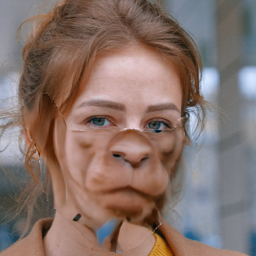

In [21]:
##############################
# Upsample the 64x64 samples #
##############################

tokens = model_up.tokenizer.encode(prompt)
tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
    tokens, options_up['text_ctx']
)

# Create the model conditioning dict.
model_kwargs = dict(
    # Low-res image to upsample.
    low_res=((samples+1)*127.5).round()/127.5 - 1,

    # Text tokens
    tokens=th.tensor(
        [tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),

    # Masked inpainting image.
    inpaint_image=(source_image_256 * source_mask_256).repeat(batch_size, 1, 1, 1).to(device),
    inpaint_mask=source_mask_256.repeat(batch_size, 1, 1, 1).to(device),
)

def denoised_fn(x_start):
    # Force the model to have the exact right x_start predictions
    # for the part of the image which is known.
    return (
        x_start * (1 - model_kwargs['inpaint_mask'])
        + model_kwargs['inpaint_image'] * model_kwargs['inpaint_mask']
    )

# Sample from the base model.
model_up.del_cache()
up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
up_samples = diffusion_up.p_sample_loop(
    model_up,
    up_shape,
    noise=th.randn(up_shape, device=device) * upsample_temp,
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
    denoised_fn=denoised_fn,
)[:batch_size]
model_up.del_cache()

# Show the output
show_images(up_samples)